In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time, VolumeGrouper
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate, calibrate_multiple, get_data
from datastore import Store

In [2]:
sym = 'NQ'
volume = 10000
start_date = '20190101'
end_date = '20191231'

In [3]:
#data = VolumeGrouper(get_data(sym, start_date, end_date), volume).df
data = get_data(sym, start_date, end_date)

In [4]:
def ema(data, fast, slow):
    data = data.copy()
    data['ema_slow'] = data.close.ewm(span=slow).mean()
    data['ema_fast'] = data.close.ewm(span=fast).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    return data['ema_diff']

In [5]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [6]:
def carver(data, periods):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = data['breakout_norm'].ewm(span=periods/3).mean()
    return data[f'carver_{periods}']*40

In [7]:
day = 1365*2
data['carver'] = carver(data, int(day*2))
data['ema'] = ema(data, day*2, day*6)
data['carver_bin'] = np.sign(data['carver'])
data['ema_bin'] = np.sign(data['ema'])
data['forecast'] = (data['carver_bin'] == data['ema_bin']) * data['carver_bin']

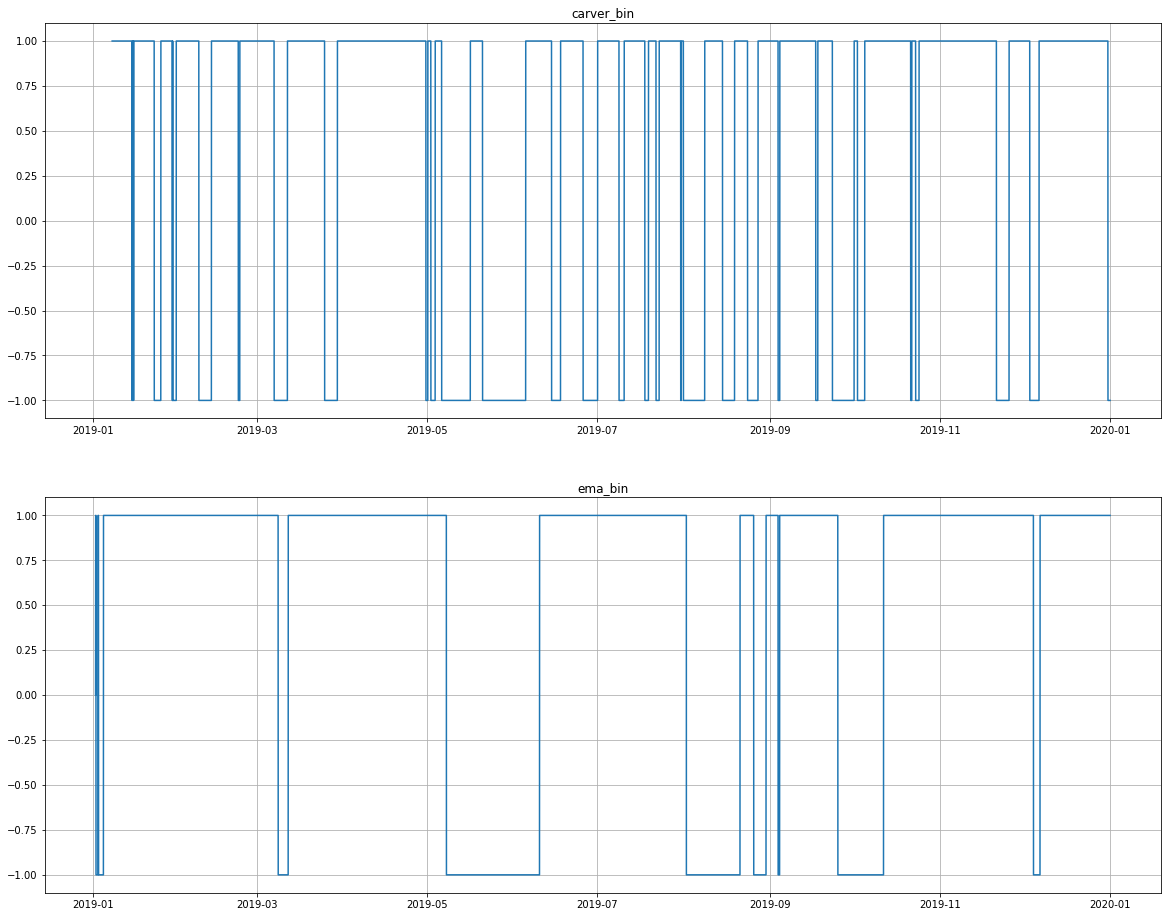

In [8]:
plot(data[['carver_bin', 'ema_bin']])

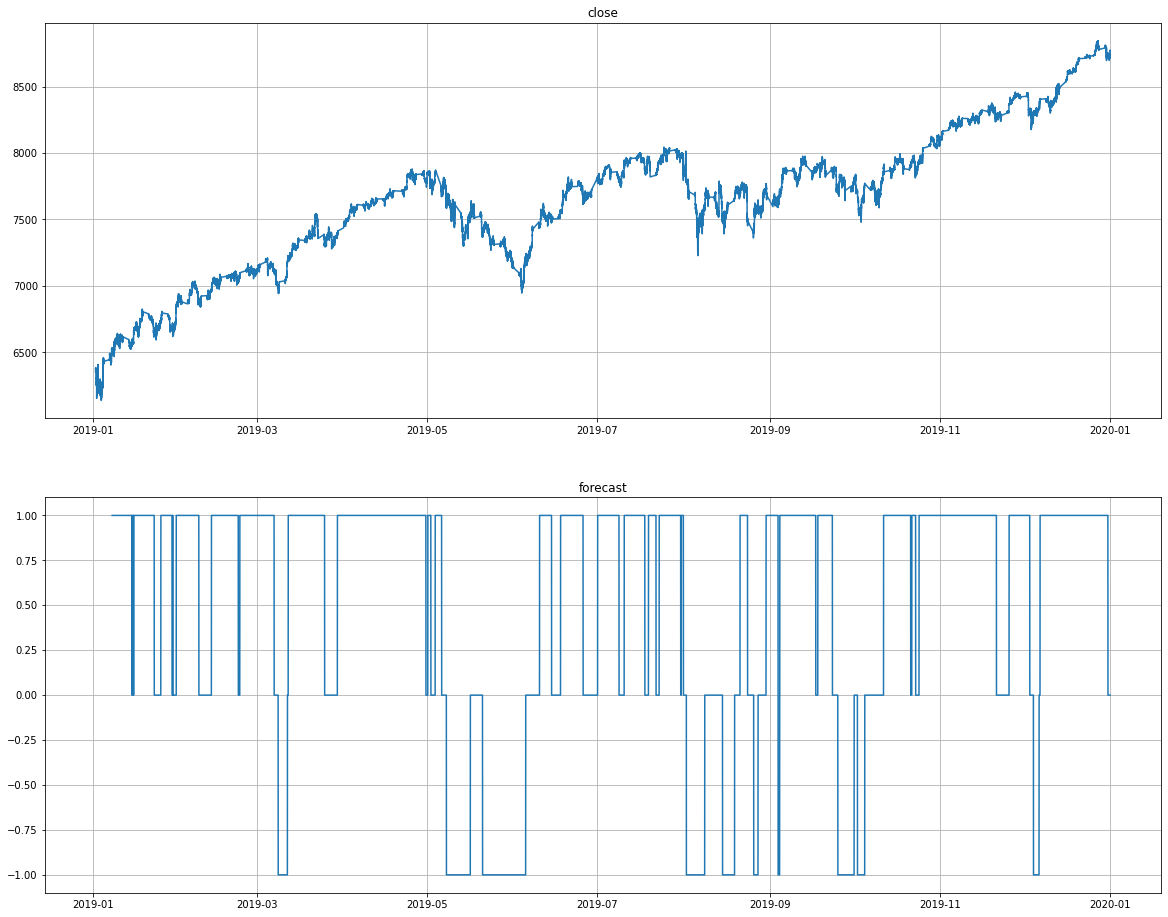

In [9]:
plot(data[['close', 'forecast']])

In [10]:
data.loc['20190719 20:00':].head(30)

,open,high,low,close,volume,average,barCount,carver,ema,carver_bin,ema_bin,forecast
date,,,,,,,,,,,,
2019-07-19 20:00:00,7918.25,7921.25,7917.00,7920.75,965,7918.925,485,3.619452,40.494679,1.0,1.0,1.0
2019-07-19 20:01:00,7920.75,7922.00,7919.50,7922.00,707,7920.800,344,3.616932,40.487869,1.0,1.0,1.0
2019-07-19 20:02:00,7921.75,7925.25,7920.00,7925.00,738,7922.925,406,3.615210,40.481793,1.0,1.0,1.0
2019-07-19 20:03:00,7925.00,7925.75,7922.75,7923.50,701,7924.225,306,3.613091,40.475352,1.0,1.0,1.0
2019-07-19 20:04:00,7923.25,7923.50,7919.25,7920.25,790,7920.975,392,3.610116,40.468119,1.0,1.0,1.0
2019-07-19 20:05:00,7920.50,7921.75,7918.00,7918.25,421,7919.625,251,3.606614,40.460399,1.0,1.0,1.0
2019-07-19 20:06:00,7918.25,7919.50,7916.50,7917.50,557,7917.975,274,3.602917,40.452498,1.0,1.0,1.0
2019-07-19 20:07:00,7917.75,7918.00,7914.75,7917.25,436,7916.325,240,3.599159,40.444538,1.0,1.0,1.0
2019-07-19 20:08:00,7917.25,7918.25,7914.50,7915.00,347,7915.925,204,3.594809,40.436031,1.0,1.0,1.0


In [11]:
out = summary(data, slip=1.5, )
out.stats

,0
Annual return,0.00854876
Cumulative returns,0.00875319
Annual volatility,0.135758
Sharpe ratio,0.130155
Calmar ratio,0.0580538
Stability,0.135079
Max drawdown,-0.147256
Omega ratio,1.02508
Sortino ratio,0.187908
Skew,0.462454


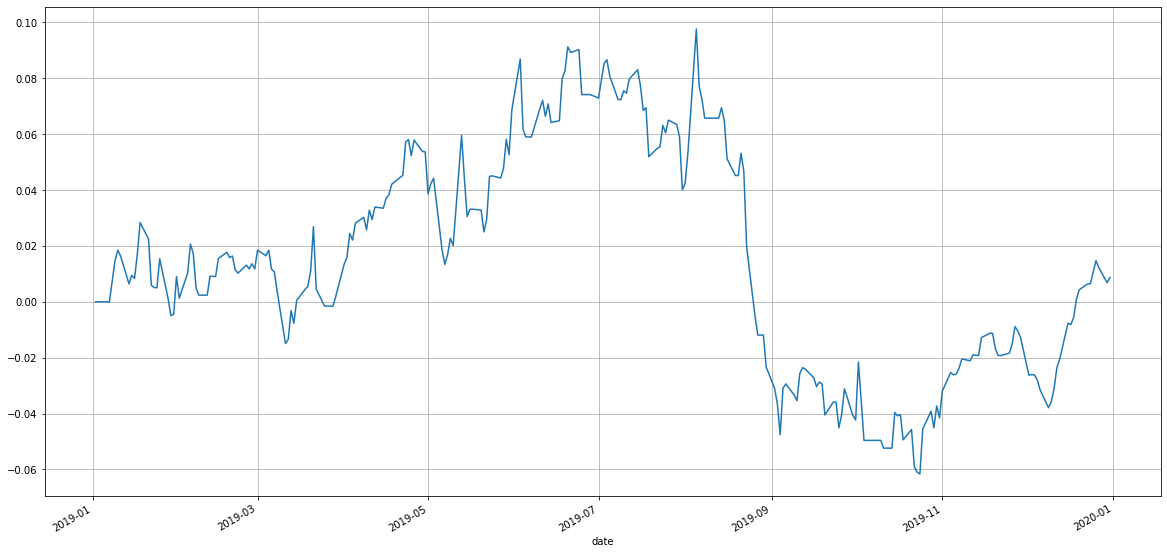

In [12]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [13]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

KeyError: 5

In [ ]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [ ]:
np.log(out.returns[19]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [ ]:
out.positions[0].head(50)

In [ ]:
out.dfs[0].loc['20190719 7:00':].head(50)